# Using Base Neural Architectures

In this notebook, the task of stance detection is tackled through neural architectures in a fully supervised way, without adoption of any pre-trained model.

## Imports and Setup

In [1]:
import torch

In [30]:
from datasets import SemEval
from torch import nn, optim
from matplotlib import pyplot as plt
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report
import numpy as np
from math import ceil
from warnings import filterwarnings
from utils import get_batch, plot_confusion_matrix

In [4]:
filterwarnings("ignore")

The following cells contains functionalities used for the pre-processing and vectorisation of text into numeric form; used as inputs to the networks.

In [5]:
def tokenise(text):        
    return text.lower().split()

In [6]:
def get_vocabulary(texts):
    vocabulary = {
        "[PAD]": 0,
        "[UNK]": 1,
        "[SEP]": 2,
        "[SOS]": 3,
        "[EOS]": 4,
    }
    for text in texts:
        for token in tokenise(text):
            if token not in vocabulary:
                vocabulary[token] = len(vocabulary)
    return vocabulary

In [7]:
def _vectorise(text, vocabulary):
    return [vocabulary[token] if token in vocabulary else vocabulary["[UNK]"] for token in tokenise(text)]

In [8]:
def vectorise(texts, vocabulary):
    return [_vectorise(text, vocabulary) for text in texts]

In [9]:
def tensorise(texts, vocabulary, maximum_length=None):
    vectors = vectorise(texts, vocabulary)
    maximum_length = max(max([len(vector) for vector in vectors]), maximum_length if maximum_length else 0)
    _vectors = []
    for vector in vectors:
        v = vector[:maximum_length] + [vocabulary["[PAD]"]] * (maximum_length - len(vector))
        _vectors.append(v)
    return torch.tensor(_vectors).cuda()

In [39]:
class TRNN(nn.Module):
    
    def __init__(self, embedding_size, vocabulary_size):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.text_rnn = nn.LSTM(embedding_size, embedding_size, batch_first=True)
        self.classifier = nn.Sequential(nn.Linear(embedding_size, 3), nn.Softmax(dim=1))
        
    def forward(self, texts, labels):
        _, (hidden_state, _) = self.text_rnn(self.embedding(texts))
        hidden_state = hidden_state.transpose(0, 1).reshape(texts.shape[0], -1)
        probabilities = self.classifier(hidden_state)
        cross_entropy_loss = nn.CrossEntropyLoss()
        loss = cross_entropy_loss(probabilities, labels)
        return probabilities, torch.argmax(probabilities, 1), loss

In [40]:
class TTRNN(nn.Module):
    
    def __init__(self, embedding_size, vocabulary_size):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.text_rnn = nn.LSTM(embedding_size, embedding_size, batch_first=True)
        self.target_rnn = nn.LSTM(embedding_size, embedding_size, batch_first=True)
        self.classifier = nn.Sequential(nn.Linear(embedding_size, 3), nn.Softmax(dim=1))
        
    def forward(self, texts, targets, labels):
        _, (hidden_state, cell_state) = self.target_rnn(self.embedding(targets))
        _, (hidden_state, _) = self.text_rnn(self.embedding(texts), (torch.zeros_like(hidden_state), cell_state))
        hidden_state = hidden_state.squeeze()
        probabilities = self.classifier(hidden_state)
        cross_entropy_loss = nn.CrossEntropyLoss()
        loss = cross_entropy_loss(probabilities, labels)
        return probabilities, torch.argmax(probabilities, 1), loss

In [41]:
class TBRNN(nn.Module):
    
    def __init__(self, embedding_size, vocabulary_size):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.text_rnn = nn.LSTM(embedding_size, embedding_size, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(nn.Linear(embedding_size * 2, 3), nn.Softmax(dim=1))
        
    def forward(self, texts, labels):
        _, (hidden_state, _) = self.text_rnn(self.embedding(texts))
        hidden_state = hidden_state.transpose(0, 1).reshape(texts.shape[0], -1)
        probabilities = self.classifier(hidden_state)
        cross_entropy_loss = nn.CrossEntropyLoss()
        loss = cross_entropy_loss(probabilities, labels)
        return probabilities, torch.argmax(probabilities, 1), loss

In [42]:
class TTBRNN(nn.Module):
    
    def __init__(self, embedding_size, vocabulary_size):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.text_rnn = nn.LSTM(embedding_size, embedding_size, batch_first=True, bidirectional=True)
        self.target_rnn = nn.LSTM(embedding_size, embedding_size, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(nn.Linear(embedding_size * 2, 3), nn.Softmax(dim=1))
        
    def forward(self, texts, targets, labels):
        _, (hidden_state, cell_state) = self.target_rnn(self.embedding(targets))
        _, (hidden_state, _) = self.text_rnn(self.embedding(texts), (torch.zeros_like(hidden_state), cell_state))
        hidden_state = hidden_state.transpose(0, 1).reshape(texts.shape[0], -1)
        probabilities = self.classifier(hidden_state)
        cross_entropy_loss = nn.CrossEntropyLoss()
        loss = cross_entropy_loss(probabilities, labels)
        return probabilities, torch.argmax(probabilities, 1), loss

In [16]:
def get_model(state_dict=None):
    model = TTRNN(32, len(vocabulary)).cuda()
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return model

## Training
The training and testing data is firstly loaded, the vocabulary is formed and it is used to tensorise the data. The training loop is then started and the loss values and evaluation metrics are recorded.

In [18]:
training, testing = SemEval.get_subtask_a_datasets("data/semeval/")

In [19]:
vocabulary = get_vocabulary(training.texts + training.targets)

In [21]:
text_length   = max([len(tokenise(text)) for text in training.texts])
target_length = max([len(tokenise(target)) for target in training.targets])

In [31]:
_z = tensorise(training.texts + testing.texts, vocabulary, maximum_length=text_length)
training_inputs = _z[:len(training)], tensorise(training.targets, vocabulary, maximum_length=target_length), torch.tensor(training.stances).cuda()
testing_inputs  = _z[len(training):], tensorise(testing.targets,  vocabulary, maximum_length=target_length), torch.tensor(testing.stances).cuda()

In [209]:
model = get_model()

In [210]:
batch_size = 48
early_stopping = 10000
optimiser = optim.Adam(model.parameters(), lr=5e-4)

In [211]:
batches = ceil(len(training) / batch_size)
batches

61

In [212]:
results = {
    "training": {
        "cross_entropy_loss": [],
        "f_1_2": [],
        "f_1_3": []
    },
    "testing": {
        "cross_entropy_loss": [],
        "f_1_2": [],
        "f_1_3": []
    }
}

In [213]:
step, steps_since_improvement = 0, 0

In [214]:
optimal_score, optimal_model_state_dict = 0., None

In [215]:
while steps_since_improvement < early_stopping:
    
    batch = get_batch(step, batch_size, training_inputs)
    
    _, predictions, loss = model(*batch)
    scores = f1_score(batch[-1].cpu(), predictions.cpu(), average=None)
    scores = (np.mean(scores[1:]), np.mean(scores[:]))
    
    results["training"]["cross_entropy_loss"].append(float(loss))
    results["training"]["f_1_2"].append(scores[0])
    results["training"]["f_1_3"].append(scores[1])
    
    loss.backward()
    optimiser.step()
    model.zero_grad()
    
    _, predictions, loss = model(*testing_inputs)
    scores = f1_score(testing.stances, predictions.cpu(), average=None)
    scores = (np.mean(scores[1:]), np.mean(scores[:]))
    
    results["testing"]["cross_entropy_loss"].append(float(loss))
    results["testing"]["f_1_2"].append(scores[0])
    results["testing"]["f_1_3"].append(scores[1])
    
    score = np.mean(scores)
    
    if score > optimal_score:
        optimal_score, optimal_model_state_dict = score, deepcopy(model.state_dict())
        print("{}\t{}\t{}\t{}".format(step, *scores, score))
        steps_since_improvement = 0
    else:
        steps_since_improvement += 1
    
    step += 1

0	0.36372898624554256	0.2424859908303617	0.3031074885379521
1	0.3640529531568228	0.2427019687712152	0.30337746096401896
2287	0.3671823469448941	0.24478823129659608	0.3059852891207451
2298	0.37061460698606535	0.2470764046573769	0.3088455058217211
2302	0.37096000479702584	0.2473066698646839	0.30913333733085485
2331	0.3902854378326076	0.2601902918884051	0.3252378648605063
2332	0.43580767978358337	0.29329327412569467	0.36455047695463905
2334	0.5513556119669414	0.41283789768989515	0.4820967548284183
2335	0.6394351119894599	0.43438724065154277	0.5369111763205013
2336	0.6441248866433475	0.4322778214246066	0.5382013540339771
2355	0.6465746606334841	0.43104977375565606	0.5388122171945701
2358	0.6469022655200982	0.4312681770133988	0.5390852212667485
2359	0.6477755132303596	0.4318503421535731	0.5398129276919663
2360	0.6489571071324395	0.4326380714216263	0.5407975892770329
2361	0.6498316498316499	0.4332210998877666	0.5415263748597082
2369	0.6501535687899894	0.43343571252665963	0.5417946406583245
2

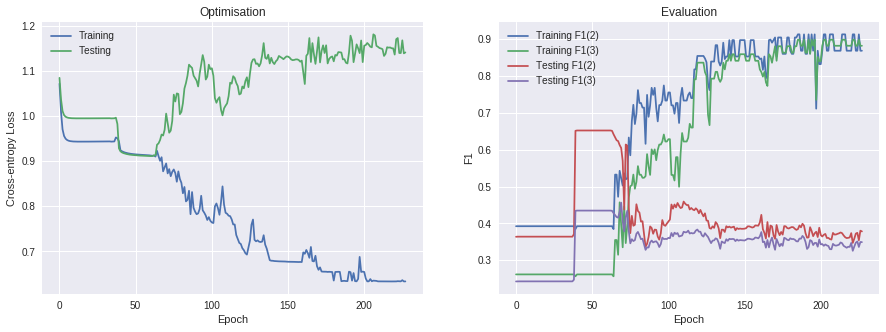

In [216]:
plt.style.use("seaborn")
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.title("Optimisation")
plt.plot(results["training"]["cross_entropy_loss"][::batches])
plt.plot(results["testing"]["cross_entropy_loss"][::batches])
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy Loss")
plt.legend(["Training", "Testing"])

plt.subplot(1, 2, 2)
plt.title("Evaluation")
plt.plot(results["training"]["f_1_2"][::batches])
plt.plot(results["training"]["f_1_3"][::batches])
plt.plot(results["testing"]["f_1_2"][::batches])
plt.plot(results["testing"]["f_1_3"][::batches])
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend(["Training F1(2)", "Training F1(3)", "Testing F1(2)", "Testing F1(3)"])

## Evaluation

In [217]:
model = get_model(optimal_model_state_dict)

In [218]:
_, predictions, _ = model(*testing_inputs)

In [219]:
print(classification_report(testing.stances, predictions.cpu()))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       230
           1       0.73      0.41      0.53       304
           2       0.65      0.98      0.78       715

    accuracy                           0.66      1249
   macro avg       0.46      0.46      0.44      1249
weighted avg       0.55      0.66      0.58      1249



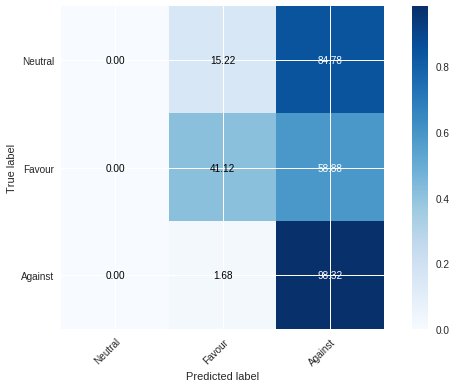

In [220]:
plot_confusion_matrix(testing.stances, predictions.cpu())